<a href="https://colab.research.google.com/github/cga-harvard/Geotweets-Stoicism-analysis/blob/main/Geotweets_Stoicism_Analysis_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##üöÄ Block 1 ‚Äî Configuration and Keyword Compilation

In [ ]:
# üöÄ Stoicism Extraction v5 Hybrid ‚Äî Block 1: Configuration & Keywords

import os
import gzip
import glob
import re
import pandas as pd
from multiprocessing import Pool, cpu_count
import fasttext
import warnings

warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

# -----------------------------
# CONFIGURATION
# -----------------------------
DATA_ROOT = "/n/holylabs/LABS/cga/Lab/data/geo-tweets/cga-sbg-tweets/"
OUTPUT_DIR = "/n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

FASTTEXT_PATH = "lid.176.bin"
YEARS = list(range(2010, 2024))
NUM_CORES = 44
MIN_TEXT_LEN = 20

# -----------------------------
# KEYWORDS
# -----------------------------
wildcard_keywords = [
    "altrui", "aristot", "cosmop", "epictet", "epicur", "eudaimon", "hedon", "philosoph",
    "plato", "pythago", "socrat", "stioc", "stoic"
]
exact_keywords = [
    "amorfati", "aurelius", "chrysippus", "cicero", "cleanthes", "commongood", "dichotomyofcontrol",
    "diogenes", "hadot", "humandignity", "humanworth", "jordanpeterson", "mattis", "mementomori",
    "moralinjury", "moralaction", "moralprogress", "moralpurpose", "musoniusrufus", "nussbaum",
    "peripatetic", "pigliucci", "ryanholiday", "seneca", "stockdale", "timferriss", "zeno"
]

# Compile non-capturing regex pattern
regex_pattern = re.compile(
    r"\b(?:"
    + "|".join([f"{kw}\\w*" for kw in wildcard_keywords] + exact_keywords)
    + r")\b",
    flags=re.IGNORECASE
)

In [ ]:
##üöÄ Block 2 ‚Äî File Processing Function with Optimized

In [ ]:
# üöÄ Block 2 ‚Äî Optimized file processor using fastText with multiprocessing

# Load fastText model once per process (global scope inside subprocess)
def load_fasttext_model():
    global model
    model = fasttext.load_model(FASTTEXT_PATH)

def is_english(text):
    try:
        text = text.strip().replace("\n", "")
        if len(text) < MIN_TEXT_LEN:
            return False
        return model.predict(text)[0][0] == '__label__en'
    except:
        return False

def process_file(file_path):
    try:
        with gzip.open(file_path, 'rt', encoding='utf-8') as f:
            df = pd.read_csv(f, sep='\t', on_bad_lines='skip', dtype=str)

        if 'text' not in df.columns:
            return pd.DataFrame()

        df = df.dropna(subset=["text"])
        df = df[df["text"].str.contains(regex_pattern, na=False, regex=True)]
        df = df[df["text"].apply(is_english)]

        return df

    except Exception as e:
        print(f"‚ö†Ô∏è Error in {os.path.basename(file_path)}: {e}")
        return pd.DataFrame()

In [ ]:
##üöÄ Block 3 ‚Äî Yearly Extraction Loop with Realtime Logging

In [ ]:
# üöÄ Block 3 ‚Äî Yearly Extraction (Full Auto-run 2010‚Äì2023)

def run_year(year):
    input_dir = os.path.join(DATA_ROOT, str(year))
    output_path = os.path.join(OUTPUT_DIR, f"filtered_tweets_{year}.csv.gz")

    if not os.path.exists(input_dir):
        print(f"‚ö†Ô∏è Skipping {year} ‚Äî input folder not found: {input_dir}", flush=True)
        return

    files = sorted(glob.glob(os.path.join(input_dir, "*.csv.gz")))
    if not files:
        print(f"‚ö†Ô∏è Skipping {year} ‚Äî no .csv.gz files found.", flush=True)
        return

    print(f"\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üöÄ Processing {year} ({len(files)} files) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)
    from time import time
    start = time()

    with Pool(processes=NUM_CORES, initializer=load_fasttext_model) as pool:
        results = pool.map(process_file, files)

    filtered_df = pd.concat(results, ignore_index=True)
    filtered_df.to_csv(output_path, index=False, compression="gzip")

    duration = time() - start
    print(f"\n‚úÖ Year {year} complete ‚Äî {len(filtered_df):,} tweets saved.", flush=True)
    print(f"üïí Duration: {duration:.2f} seconds", flush=True)
    print(f"üìÅ Output saved to: {output_path}\n", flush=True)

# ‚úÖ Auto-run for full dataset (2010‚Äì2023)
for year in YEARS:
    run_year(year)


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üöÄ Processing 2010 (79 files) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

‚úÖ Year 2010 complete ‚Äî 0 tweets saved.
üïí Duration: 0.31 seconds
üìÅ Output saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/filtered_tweets_2010.csv.gz


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üöÄ Processing 2011 (1172 files) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ

‚úÖ Year 2011 complete ‚Äî 1 tweets saved.
üïí Duration: 0.57 seconds
üìÅ Output saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/filtered_tweets_2011.csv.gz


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üöÄ Processing 2012 (7038 files) ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

In [ ]:
##üöÄ Block 4 ‚Äî Final Summary and Completion Log

In [ ]:
# üöÄ Block 4 ‚Äî Final Summary after Extraction

from time import time

def summarize_extraction(output_folder):
    print("\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üìä FINAL SUMMARY ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))
    total_tweets = 0
    summary = []

    for file in files:
        year = os.path.basename(file).split("_")[-1].replace(".csv.gz", "")
        try:
            df = pd.read_csv(file, compression='gzip', dtype=str, usecols=["text"])
            count = len(df)
            summary.append((year, count))
            total_tweets += count
            print(f"üìÖ Year {year}: {count:,} tweets", flush=True)
        except Exception as e:
            print(f"‚ö†Ô∏è Error reading {file}: {e}", flush=True)

    print("\n‚úÖ Extraction complete across", len(files), "years.", flush=True)
    print(f"üî¢ Total tweets extracted: {total_tweets:,}\n", flush=True)

# ‚úÖ Auto-run summary after extraction
start_summary = time()
summarize_extraction(OUTPUT_DIR)
print(f"üïí Summary generated in {time() - start_summary:.2f} seconds.\n", flush=True)


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üìä FINAL SUMMARY ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚ö†Ô∏è Error reading /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/filtered_tweets_2010.csv.gz: No columns to parse from file
üìÖ Year 2011: 1 tweets
üìÖ Year 2012: 1,264 tweets
üìÖ Year 2013: 152,749 tweets
üìÖ Year 2014: 297,229 tweets
üìÖ Year 2015: 146,473 tweets
üìÖ Year 2016: 41,025 tweets
üìÖ Year 2017: 54,703 tweets
üìÖ Year 2018: 114,545 tweets
üìÖ Year 2019: 233,394 tweets
üìÖ Year 2020: 203,913 tweets
üìÖ Year 2021: 151,979 tweets
üìÖ Year 2022: 213,500 tweets
üìÖ Year 2023: 45,549 tweets

‚úÖ Extraction complete across 14 years.
üî¢ Total tweets extracted: 1,656,324

üïí Summary generated in 9.46 seconds.



In [ ]:
##üöÄ Block 5 ‚Äî Semantic Validation Sample

In [ ]:
# üöÄ Block 5 ‚Äî Semantic Validation Sample (Auto-run)

import random
from collections import Counter

# -----------------------------
# CONFIGURATION
# -----------------------------
SAMPLE_SIZE_PER_YEAR = 50
SAMPLE_OUTPUT = os.path.join(OUTPUT_DIR, "sample_semantic_validation.csv")

# Safe regex pattern for semantic detection (already defined as regex_pattern)

# -----------------------------
# FUNCTION
# -----------------------------
def generate_sample(output_folder, sample_size):
    print("\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üì¶ GENERATING SEMANTIC SAMPLE ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)
    samples = []
    term_counter = Counter()

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        year = os.path.basename(file).split("_")[-1].replace(".csv.gz", "")
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "text" not in df.columns or df.empty:
                print(f"‚ö†Ô∏è Skipping {year}: No valid text found.", flush=True)
                continue

            n_samples = min(sample_size, len(df))
            df_sample = df.sample(n=n_samples, random_state=42)

            for _, row in df_sample.iterrows():
                text = str(row.get("text", ""))
                found_terms = regex_pattern.findall(text)
                terms_detected = ", ".join(sorted(set(found_terms)))
                term_counter.update(t.lower() for t in found_terms)

                samples.append({
                    "year": year,
                    "text": text,
                    "terms_detected": terms_detected
                })

            print(f"üìÖ Sampled {n_samples} tweets for year {year}.", flush=True)

        except Exception as e:
            print(f"‚ö†Ô∏è Error sampling {year}: {e}", flush=True)

    if samples:
        pd.DataFrame(samples).to_csv(SAMPLE_OUTPUT, index=False)
        print(f"\n‚úÖ Sample saved to: {SAMPLE_OUTPUT}", flush=True)
        print(f"üî¢ Total sample size: {len(samples):,} tweets", flush=True)
    else:
        print("\n‚ö†Ô∏è No samples generated.", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
generate_sample(OUTPUT_DIR, SAMPLE_SIZE_PER_YEAR)


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üì¶ GENERATING SEMANTIC SAMPLE ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚ö†Ô∏è Error sampling 2010: No columns to parse from file
üìÖ Sampled 1 tweets for year 2011.
üìÖ Sampled 50 tweets for year 2012.
üìÖ Sampled 50 tweets for year 2013.
üìÖ Sampled 50 tweets for year 2014.
üìÖ Sampled 50 tweets for year 2015.
üìÖ Sampled 50 tweets for year 2016.
üìÖ Sampled 50 tweets for year 2017.
üìÖ Sampled 50 tweets for year 2018.
üìÖ Sampled 50 tweets for year 2019.
üìÖ Sampled 50 tweets for year 2020.
üìÖ Sampled 50 tweets for year 2021.
üìÖ Sampled 50 tweets for year 2022.
üìÖ Sampled 50 tweets for year 2023.

‚úÖ Sample saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/sample_semantic_validation.csv
üî¢ Total sample size: 601 tweets


In [ ]:
##üöÄ Block 6 ‚Äî Keyword Frequency by Year

In [ ]:
# üöÄ Block 6 ‚Äî Keyword Frequency Analysis (Auto-run)

# -----------------------------
# CONFIGURATION
# -----------------------------
FREQ_OUTPUT = os.path.join(OUTPUT_DIR, "keyword_frequencies_by_year.csv")

# -----------------------------
# FUNCTION
# -----------------------------
def generate_keyword_frequencies(output_folder):
    print("\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üìà GENERATING KEYWORD FREQUENCIES ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)
    all_counts = []

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        year = os.path.basename(file).split("_")[-1].replace(".csv.gz", "")
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "text" not in df.columns or df.empty:
                print(f"‚ö†Ô∏è Skipping {year}: No valid text found.", flush=True)
                continue

            year_counter = Counter()

            for text in df["text"].dropna():
                found_terms = regex_pattern.findall(str(text))
                year_counter.update([term.lower() for term in found_terms])

            for term, count in year_counter.items():
                all_counts.append({
                    "year": year,
                    "term": term,
                    "count": count
                })

            print(f"üìÖ Counted terms for year {year}.", flush=True)

        except Exception as e:
            print(f"‚ö†Ô∏è Error processing {year}: {e}", flush=True)

    if all_counts:
        freq_df = pd.DataFrame(all_counts)
        freq_df = freq_df.sort_values(["year", "term"]).reset_index(drop=True)
        freq_df.to_csv(FREQ_OUTPUT, index=False)
        print(f"\n‚úÖ Keyword frequencies saved to: {FREQ_OUTPUT}", flush=True)
    else:
        print("\n‚ö†Ô∏è No keyword counts generated.", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
generate_keyword_frequencies(OUTPUT_DIR)


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üìà GENERATING KEYWORD FREQUENCIES ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚ö†Ô∏è Error processing 2010: No columns to parse from file
üìÖ Counted terms for year 2011.
üìÖ Counted terms for year 2012.
üìÖ Counted terms for year 2013.
üìÖ Counted terms for year 2014.
üìÖ Counted terms for year 2015.
üìÖ Counted terms for year 2016.
üìÖ Counted terms for year 2017.
üìÖ Counted terms for year 2018.
üìÖ Counted terms for year 2019.
üìÖ Counted terms for year 2020.
üìÖ Counted terms for year 2021.
üìÖ Counted terms for year 2022.
üìÖ Counted terms for year 2023.

‚úÖ Keyword frequencies saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/keyword_frequencies_by_year.csv


In [ ]:
##üöÄ Block 7 ‚Äî Visualization of Keyword Trends


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üìä PLOTTING TRENDS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ


/tmp/ipykernel_1456854/3077747609.py:45: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


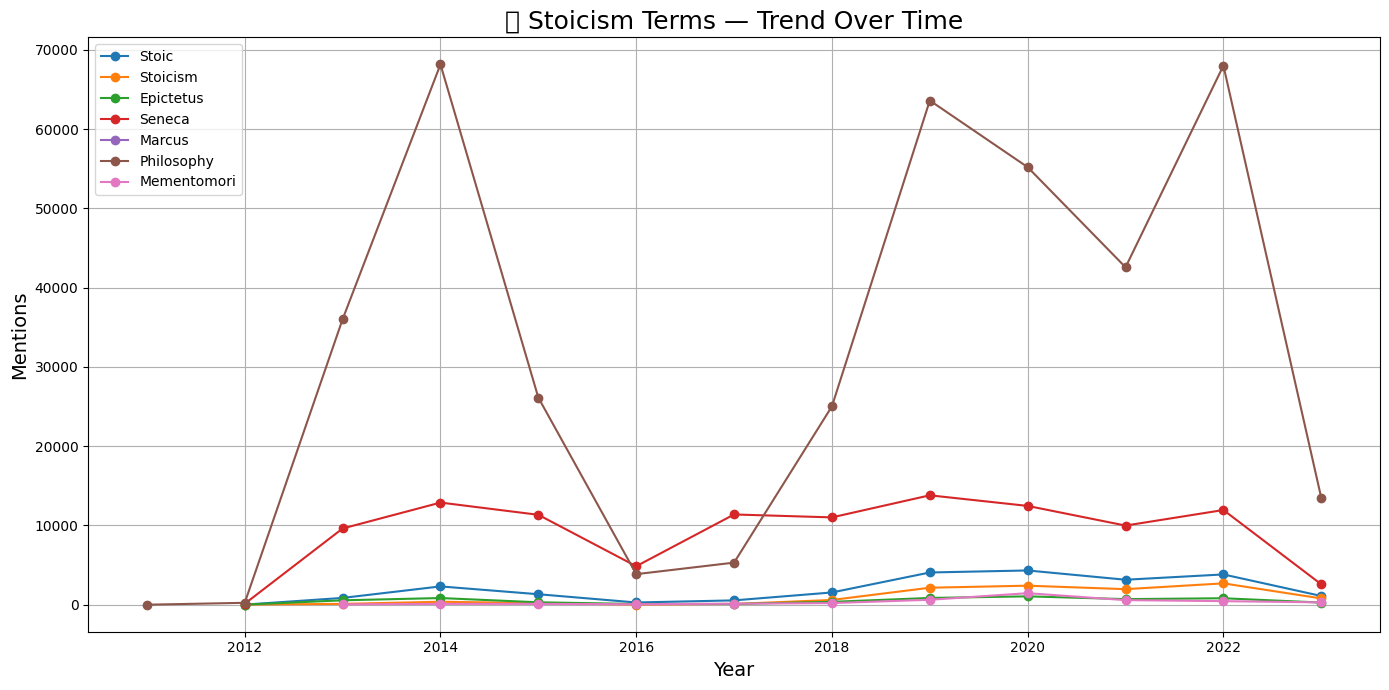

/tmp/ipykernel_1456854/3077747609.py:54: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


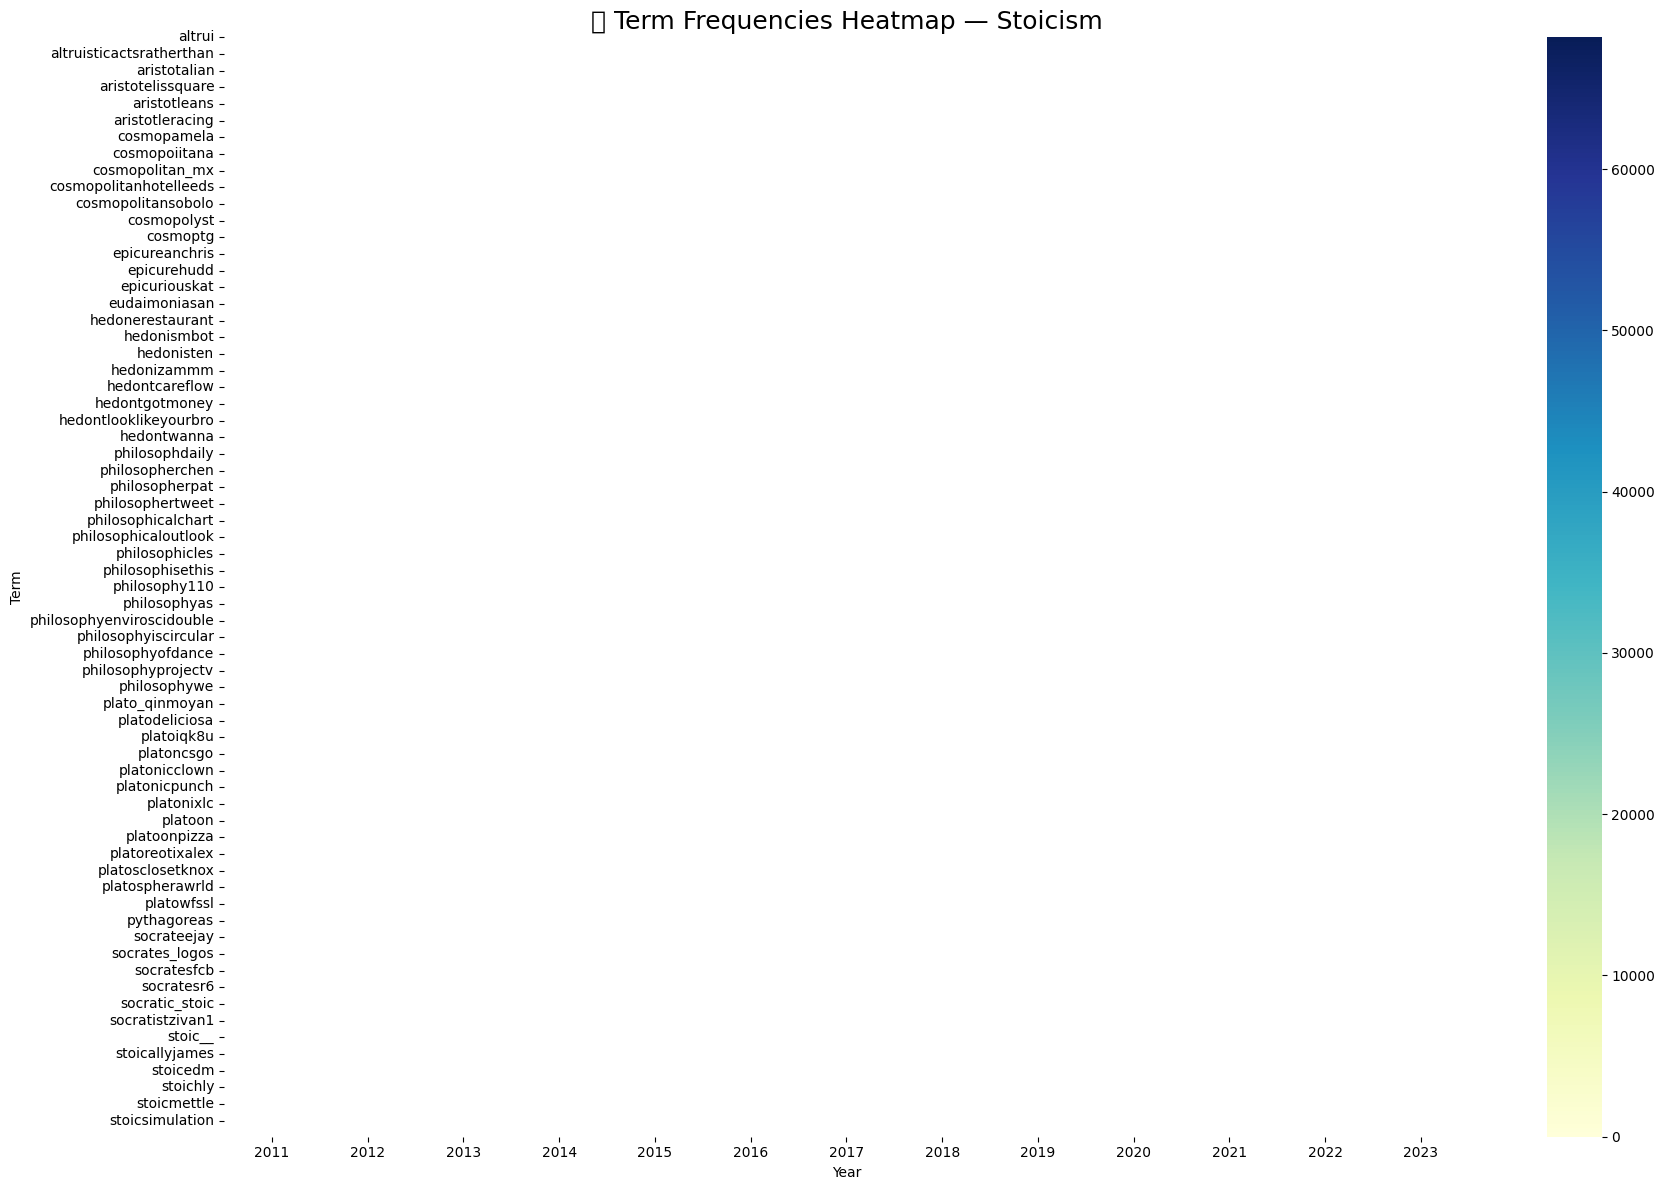


‚úÖ Trend plots generated successfully!


In [ ]:
# üöÄ Block 7 ‚Äî Visualization of Keyword Trends (Auto-run)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# -----------------------------
# CONFIGURATION
# -----------------------------
FREQ_FILE = os.path.join(OUTPUT_DIR, "keyword_frequencies_by_year.csv")
TOP_TERMS_TO_PLOT = [
    "stoic", "stoicism", "epictetus", "seneca", "marcus", "philosophy", "mementomori"
]
MIN_YEAR = 2010
MAX_YEAR = 2023

# -----------------------------
# FUNCTION
# -----------------------------
def plot_keyword_trends(freq_file):
    print("\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üìä PLOTTING TRENDS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)

    try:
        df = pd.read_csv(freq_file, dtype=str)
        df["year"] = df["year"].astype(int)
        df["count"] = df["count"].astype(int)

        # Filter years of interest
        df = df[(df["year"] >= MIN_YEAR) & (df["year"] <= MAX_YEAR)]

        # Create pivot for heatmap
        pivot_df = df.pivot_table(index="term", columns="year", values="count", fill_value=0)

        # üìà Plot line chart for selected top terms
        plt.figure(figsize=(14, 7))
        for term in TOP_TERMS_TO_PLOT:
            subset = df[df["term"] == term.lower()]
            plt.plot(subset["year"], subset["count"], marker='o', label=term.capitalize())

        plt.title("üìà Stoicism Terms ‚Äî Trend Over Time", fontsize=18)
        plt.xlabel("Year", fontsize=14)
        plt.ylabel("Mentions", fontsize=14)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # üî• Plot full heatmap (optional)
        plt.figure(figsize=(18, 12))
        sns.heatmap(pivot_df, cmap="YlGnBu", linewidths=0.5, annot=False)
        plt.title("üî• Term Frequencies Heatmap ‚Äî Stoicism", fontsize=18)
        plt.xlabel("Year")
        plt.ylabel("Term")
        plt.tight_layout()
        plt.show()

        print("\n‚úÖ Trend plots generated successfully!", flush=True)

    except Exception as e:
        print(f"‚ö†Ô∏è Error plotting trends: {e}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
plot_keyword_trends(FREQ_FILE)

In [ ]:
##üöÄ Block 8 ‚Äî Spatial Heatmap (Folium Map Auto-save)

In [ ]:
# üöÄ Block 8 ‚Äî Spatial Heatmap of Stoicism Tweets (Auto-run)

import folium
from folium.plugins import HeatMap
import pandas as pd
import glob
import os

# -----------------------------
# CONFIGURATION
# -----------------------------
MAP_OUTPUT = os.path.join(OUTPUT_DIR, "stoicism_spatial_heatmap.html")

# -----------------------------
# FUNCTION
# -----------------------------
def generate_spatial_heatmap(output_folder):
    print("\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üåé GENERATING SPATIAL HEATMAP ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)

    coords = []

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "latitude" not in df.columns or "longitude" not in df.columns:
                print(f"‚ö†Ô∏è Skipping {file}: No latitude/longitude columns.", flush=True)
                continue

            df = df.dropna(subset=["latitude", "longitude"])
            df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
            df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
            df = df.dropna(subset=["latitude", "longitude"])

            coords.extend(df[["latitude", "longitude"]].values.tolist())

            print(f"üì¶ Loaded {len(df)} geolocated tweets from {os.path.basename(file)}", flush=True)

        except Exception as e:
            print(f"‚ö†Ô∏è Error reading {file}: {e}", flush=True)

    if not coords:
        print("\n‚ö†Ô∏è No coordinates found to plot.", flush=True)
        return

    # Create map centered at approximate global mean
    mean_lat = sum(c[0] for c in coords) / len(coords)
    mean_lon = sum(c[1] for c in coords) / len(coords)

    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=2, tiles="CartoDB positron")
    HeatMap(coords, radius=8, blur=6, min_opacity=0.5).add_to(m)

    m.save(MAP_OUTPUT)
    print(f"\n‚úÖ Spatial heatmap saved to: {MAP_OUTPUT}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
generate_spatial_heatmap(OUTPUT_DIR)


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üåé GENERATING SPATIAL HEATMAP ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚ö†Ô∏è Error reading /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/filtered_tweets_2010.csv.gz: No columns to parse from file
üì¶ Loaded 1 geolocated tweets from filtered_tweets_2011.csv.gz
üì¶ Loaded 1264 geolocated tweets from filtered_tweets_2012.csv.gz
üì¶ Loaded 152732 geolocated tweets from filtered_tweets_2013.csv.gz
üì¶ Loaded 297214 geolocated tweets from filtered_tweets_2014.csv.gz
üì¶ Loaded 146440 geolocated tweets from filtered_tweets_2015.csv.gz
üì¶ Loaded 41005 geolocated tweets from filtered_tweets_2016.csv.gz
üì¶ Loaded 54698 geolocated tweets from filtered_tweets_2017.csv.gz
üì¶ Loaded 114540 geolocated tweets from filtered_tweets_2018.csv.gz
üì¶ Loaded 233393 geolocated tweets from filtered_tweets_2019.csv.

In [ ]:
##Block 9 ‚Äî Yearly Tweets Overview (Barras e Termos)


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üìä PLOTTING YEARLY TWEET COUNTS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ


/tmp/ipykernel_1456854/2750897587.py:33: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


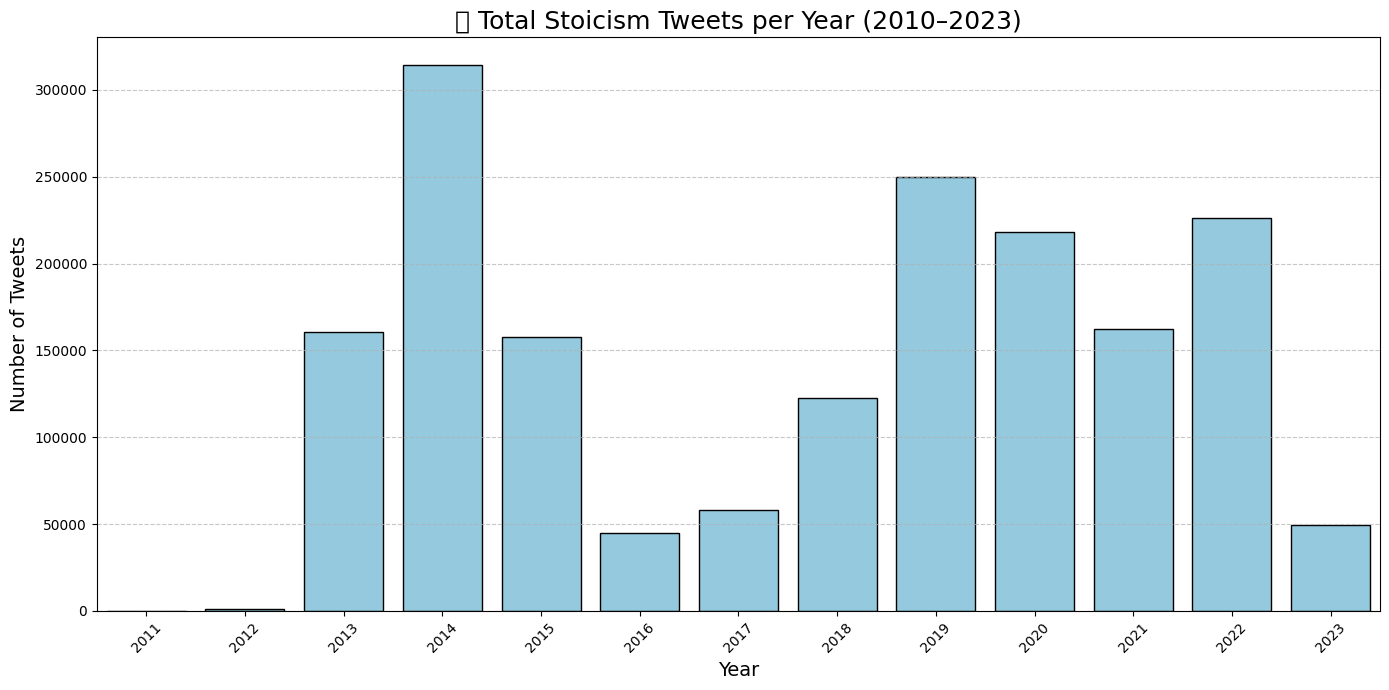

/tmp/ipykernel_1456854/2750897587.py:49: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/n/home03/rpereiraalbuquerque/meu_ambiente_bertopic/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


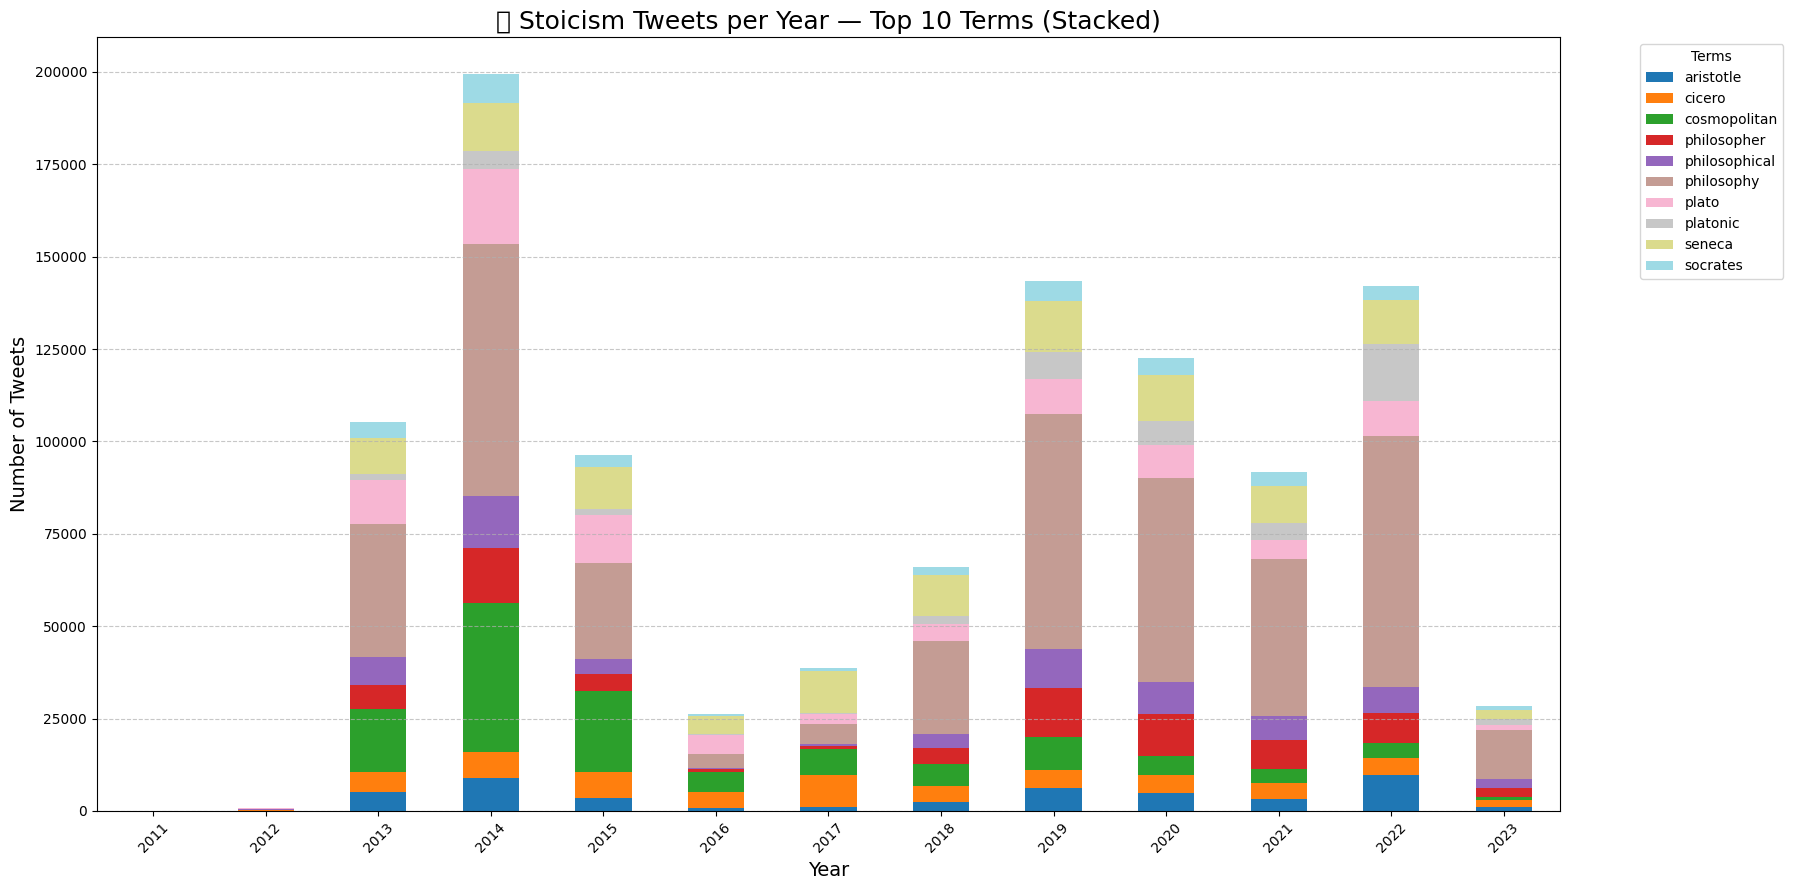


‚úÖ Yearly tweet summary plots generated!


In [ ]:
# üöÄ Block 9 ‚Äî Yearly Tweet Counts and Term Breakdown (Auto-run)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# CONFIGURATION
# -----------------------------
FREQ_FILE = os.path.join(OUTPUT_DIR, "keyword_frequencies_by_year.csv")

# -----------------------------
# FUNCTION
# -----------------------------
def plot_yearly_tweet_summary(freq_file):
    print("\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üìä PLOTTING YEARLY TWEET COUNTS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)

    try:
        df = pd.read_csv(freq_file, dtype=str)
        df["year"] = df["year"].astype(int)
        df["count"] = df["count"].astype(int)

        # üìà 1. Total tweets per year (sum over all terms)
        total_per_year = df.groupby("year")["count"].sum().reset_index()

        plt.figure(figsize=(14, 7))
        sns.barplot(x="year", y="count", data=total_per_year, color="skyblue", edgecolor="black")
        plt.title("üìä Total Stoicism Tweets per Year (2010‚Äì2023)", fontsize=18)
        plt.xlabel("Year", fontsize=14)
        plt.ylabel("Number of Tweets", fontsize=14)
        plt.xticks(rotation=45)
        plt.grid(True, axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

        # üìä 2. Barplot Stacked by Terms (Top 10 terms)
        top_terms = df.groupby("term")["count"].sum().nlargest(10).index.tolist()
        df_top = df[df["term"].isin(top_terms)]

        pivot_df = df_top.pivot_table(index="year", columns="term", values="count", fill_value=0)

        pivot_df.plot(kind="bar", stacked=True, figsize=(18, 9), colormap="tab20")
        plt.title("üìä Stoicism Tweets per Year ‚Äî Top 10 Terms (Stacked)", fontsize=18)
        plt.xlabel("Year", fontsize=14)
        plt.ylabel("Number of Tweets", fontsize=14)
        plt.legend(title="Terms", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(True, axis="y", linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\n‚úÖ Yearly tweet summary plots generated!", flush=True)

    except Exception as e:
        print(f"‚ö†Ô∏è Error plotting yearly tweet summary: {e}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
plot_yearly_tweet_summary(FREQ_FILE)

In [ ]:
##üöÄ Block 10 ‚Äî Geospatial Clustering with HDBSCAN

In [ ]:
# üöÄ Block 10 ‚Äî Geospatial Clustering with HDBSCAN (Auto-run)

import pandas as pd
import numpy as np
import glob
import os
import hdbscan
import folium
from folium.plugins import MarkerCluster

# -----------------------------
# CONFIGURATION
# -----------------------------
CLUSTER_OUTPUT = os.path.join(OUTPUT_DIR, "stoicism_cluster_map.html")
MIN_SAMPLES = 10
MIN_CLUSTER_SIZE = 30

# -----------------------------
# FUNCTION
# -----------------------------
def run_spatial_clustering(output_folder):
    print("\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üß≠ RUNNING GEOSPATIAL CLUSTERING ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)

    coords = []

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "latitude" not in df.columns or "longitude" not in df.columns:
                continue

            df = df.dropna(subset=["latitude", "longitude"])
            df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
            df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
            df = df.dropna(subset=["latitude", "longitude"])

            coords.extend(df[["latitude", "longitude"]].values.tolist())

        except Exception as e:
            print(f"‚ö†Ô∏è Error reading {file}: {e}", flush=True)

    if len(coords) < 100:
        print("‚ö†Ô∏è Not enough geolocated tweets for clustering.", flush=True)
        return

    # -----------------------------
    # HDBSCAN Clustering
    # -----------------------------
    coords_np = np.array(coords)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, min_samples=MIN_SAMPLES, metric='haversine')
    coords_rad = np.radians(coords_np)
    labels = clusterer.fit_predict(coords_rad)

    print(f"‚úÖ Clustering complete ‚Äî {len(set(labels)) - (1 if -1 in labels else 0)} clusters found", flush=True)

    # -----------------------------
    # Map Clusters
    # -----------------------------
    m = folium.Map(location=[0, 0], zoom_start=2, tiles="CartoDB positron")
    marker_cluster = MarkerCluster().add_to(m)

    for (lat, lon), label in zip(coords_np, labels):
        color = "gray" if label == -1 else f"#{hash(str(label)) & 0xFFFFFF:06x}"
        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color=color,
            fill=True,
            fill_opacity=0.6,
            popup=f"Cluster {label}" if label != -1 else "Noise"
        ).add_to(marker_cluster)

    m.save(CLUSTER_OUTPUT)
    print(f"\n‚úÖ Cluster map saved to: {CLUSTER_OUTPUT}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
run_spatial_clustering(OUTPUT_DIR)


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üß≠ RUNNING GEOSPATIAL CLUSTERING ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚ö†Ô∏è Error reading /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/filtered_tweets_2010.csv.gz: No columns to parse from file
‚úÖ Clustering complete ‚Äî 10552 clusters found

‚úÖ Cluster map saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/stoicism_cluster_map.html


In [ ]:
##üöÄ Block 11 ‚Äî Cluster Statistics Generator

In [ ]:
# üöÄ Block 11 ‚Äî Cluster Statistics Generator (Auto-run)

import pandas as pd
import numpy as np
import glob
import os
import hdbscan

# -----------------------------
# CONFIGURATION
# -----------------------------
CLUSTER_SUMMARY_OUTPUT = os.path.join(OUTPUT_DIR, "stoicism_cluster_summary.csv")
MIN_SAMPLES = 10
MIN_CLUSTER_SIZE = 30

# -----------------------------
# FUNCTION
# -----------------------------
def generate_cluster_statistics(output_folder):
    print("\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üìã GENERATING CLUSTER STATISTICS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)

    coords = []

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "latitude" not in df.columns or "longitude" not in df.columns:
                continue

            df = df.dropna(subset=["latitude", "longitude"])
            df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
            df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
            df = df.dropna(subset=["latitude", "longitude"])

            coords.extend(df[["latitude", "longitude"]].values.tolist())

        except Exception as e:
            print(f"‚ö†Ô∏è Error reading {file}: {e}", flush=True)

    if len(coords) < 100:
        print("‚ö†Ô∏è Not enough geolocated tweets for cluster stats.", flush=True)
        return

    coords_np = np.array(coords)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, min_samples=MIN_SAMPLES, metric='haversine')
    coords_rad = np.radians(coords_np)
    labels = clusterer.fit_predict(coords_rad)

    print(f"‚úÖ Clustering complete for stats ‚Äî {len(set(labels)) - (1 if -1 in labels else 0)} clusters detected.", flush=True)

    df_clusters = pd.DataFrame({
        "latitude": coords_np[:, 0],
        "longitude": coords_np[:, 1],
        "cluster": labels
    })

    # Exclude noise points
    df_clusters = df_clusters[df_clusters["cluster"] != -1]

    summary = df_clusters.groupby("cluster").agg(
        n_tweets=("cluster", "count"),
        centroid_latitude=("latitude", "mean"),
        centroid_longitude=("longitude", "mean")
    ).reset_index()

    summary = summary.sort_values(by="n_tweets", ascending=False)

    summary.to_csv(CLUSTER_SUMMARY_OUTPUT, index=False)

    print(f"\n‚úÖ Cluster summary saved to: {CLUSTER_SUMMARY_OUTPUT}", flush=True)
    print(f"üî¢ Total clusters in summary: {len(summary)}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
generate_cluster_statistics(OUTPUT_DIR)


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üìã GENERATING CLUSTER STATISTICS ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚ö†Ô∏è Error reading /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/filtered_tweets_2010.csv.gz: No columns to parse from file
‚úÖ Clustering complete for stats ‚Äî 10552 clusters detected.

‚úÖ Cluster summary saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/stoicism_cluster_summary.csv
üî¢ Total clusters in summary: 10552


In [ ]:
##üöÄ Block 12 ‚Äî Tweets by Country (Latitude and Longitude Based)

In [ ]:
import sys
!{sys.executable} -m pip install reverse_geocoder

In [ ]:
!{sys.executable} -m pip install -q pycountry

In [ ]:
# üöÄ Block 12 ‚Äî Geolocation-Based Tweet Country Summary (FINAL, STABLE VERSION)

import pandas as pd
import reverse_geocoder as rg
import pycountry
import os
import glob
import sys

# -----------------------------
# INSTALLATION (SAFE FOR JUPYTER)
# -----------------------------
!{sys.executable} -m pip install -q reverse_geocoder pycountry

# -----------------------------
# CONFIGURATION
# -----------------------------
COUNTRY_SUMMARY_OUTPUT = os.path.join(OUTPUT_DIR, "tweets_by_country.csv")
BATCH_SIZE = 10000

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -----------------------------
# FUNCTION
# -----------------------------
def generate_country_statistics(output_folder):
    print("\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üåç GENERATING TWEETS BY COUNTRY ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)

    coords = []

    files = sorted(glob.glob(os.path.join(output_folder, "filtered_tweets_*.csv.gz")))

    for file in files:
        try:
            df = pd.read_csv(file, compression="gzip", dtype=str)
            if "latitude" not in df.columns or "longitude" not in df.columns:
                continue

            df = df.dropna(subset=["latitude", "longitude"])
            df["latitude"] = pd.to_numeric(df["latitude"], errors="coerce")
            df["longitude"] = pd.to_numeric(df["longitude"], errors="coerce")
            df = df.dropna(subset=["latitude", "longitude"])

            coords.extend(df[["latitude", "longitude"]].values.tolist())

        except Exception as e:
            print(f"‚ö†Ô∏è Error reading {file}: {e}", flush=True)

    if len(coords) == 0:
        print("‚ö†Ô∏è No coordinates found.", flush=True)
        return

    print(f"üîµ Total coordinates to process: {len(coords)}", flush=True)

    # Perform reverse geocoding in batches
    results = []
    for i in range(0, len(coords), BATCH_SIZE):
        batch = coords[i:i+BATCH_SIZE]
        # üî• Convert to list of (float, float) tuples
        batch = [(float(lat), float(lon)) for lat, lon in batch]
        print(f"üåé Geocoding batch {i//BATCH_SIZE + 1} ({len(batch)} points)...", flush=True)
        results_batch = rg.search(batch, mode=2)
        results.extend(results_batch)

    countries = [result["cc"] for result in results]

    df_countries = pd.DataFrame(countries, columns=["country_code"])
    summary = df_countries.value_counts().reset_index()
    summary.columns = ["country_code", "n_tweets"]

    # Map ISO2 code to full country name
    def get_country_name(iso_code):
        try:
            return pycountry.countries.get(alpha_2=iso_code).name
        except:
            return "Unknown"

    summary["country_name"] = summary["country_code"].apply(get_country_name)

    summary = summary[["country_name", "country_code", "n_tweets"]]
    summary = summary.sort_values(by="n_tweets", ascending=False)

    summary.to_csv(COUNTRY_SUMMARY_OUTPUT, index=False)

    print(f"\n‚úÖ Country summary saved to: {COUNTRY_SUMMARY_OUTPUT}", flush=True)
    print(f"üî¢ Total countries detected: {len(summary)}", flush=True)

    print("\nüèÜ Top 10 countries by number of tweets:")
    print(summary.head(10).to_string(index=False))

# -----------------------------
# AUTO-RUN
# -----------------------------
generate_country_statistics(OUTPUT_DIR)


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üåç GENERATING TWEETS BY COUNTRY ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚ö†Ô∏è Error reading /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/filtered_tweets_2010.csv.gz: No columns to parse from file
üîµ Total coordinates to process: 1656160
üåé Geocoding batch 1 (10000 points)...
üåé Geocoding batch 2 (10000 points)...
üåé Geocoding batch 3 (10000 points)...
üåé Geocoding batch 4 (10000 points)...
üåé Geocoding batch 5 (10000 points)...
üåé Geocoding batch 6 (10000 points)...
üåé Geocoding batch 7 (10000 points)...
üåé Geocoding batch 8 (10000 points)...
üåé Geocoding batch 9 (10000 points)...
üåé Geocoding batch 10 (10000 points)...
üåé Geocoding batch 11 (10000 points)...
üåé Geocoding batch 12 (10000 points)...
üåé Geocoding batch 13 (10000 points)...
üåé Geocoding batch 14 (10000 point

In [ ]:
### üöÄ Block 13 ‚Äî Top 10 Countries Bar Chart (Save as Image)

In [ ]:
# üöÄ Block 13 ‚Äî Top 10 Countries Bar Chart (Save as Image)

import pandas as pd
import matplotlib.pyplot as plt
import os

# -----------------------------
# CONFIGURATION
# -----------------------------
INPUT_COUNTRY_FILE = os.path.join(OUTPUT_DIR, "tweets_by_country.csv")
OUTPUT_IMAGE_FILE = os.path.join(OUTPUT_DIR, "top10_countries_stoicism.png")

# -----------------------------
# FUNCTION
# -----------------------------
def plot_top10_countries(input_file, output_image):
    print("\n‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üé® PLOTTING TOP 10 COUNTRIES ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ", flush=True)

    df = pd.read_csv(input_file)

    # Sort and select top 10
    df_top10 = df.sort_values(by="n_tweets", ascending=False).head(10)

    # Plot
    plt.figure(figsize=(12, 8))
    bars = plt.barh(df_top10["country_name"], df_top10["n_tweets"])
    plt.xlabel("Number of Tweets", fontsize=14)
    plt.title("Top 10 Countries ‚Äî Stoicism Discourse (2010‚Äì2023)", fontsize=16)
    plt.gca().invert_yaxis()  # Most tweets at the top
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Add labels to bars
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 500, bar.get_y() + bar.get_height()/2,
                 f"{width:,}", va='center', fontsize=12)

    plt.tight_layout()
    plt.savefig(output_image, dpi=300)
    plt.close()

    print(f"‚úÖ Top 10 countries chart saved to: {output_image}", flush=True)

# -----------------------------
# AUTO-RUN
# -----------------------------
plot_top10_countries(INPUT_COUNTRY_FILE, OUTPUT_IMAGE_FILE)


‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ üé® PLOTTING TOP 10 COUNTRIES ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
‚úÖ Top 10 countries chart saved to: /n/netscratch/cga/Lab/rpalbuquerque/Stoicism_v5/top10_countries_stoicism.png
